<img src=./logo.png><br>
* ref : https://www.kaggle.com/c/titanic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

                                                      #y_true, y_pred
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score,  f1_score
from sklearn.metrics import precision_recall_curve    #y_true, probas_pred
from sklearn.metrics import roc_auc_score, roc_curve  #y_true, y_score


import warnings
warnings.filterwarnings(action='ignore')


# Data Load

In [2]:
train = pd.read_csv("./dataset/train.csv")

In [3]:
print(train.shape)
print(train.info())
train.head()

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA : 사전 데이터 탐색

## Survived : Traget Feature

In [4]:
train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

## 레코드수 == 유니크수
* 대체로 분석 대상에서 제외(삭제)

* 간결 :  결측 or 유니크값

In [5]:
print(train.isna().sum()  [train.isna().sum() >0  ] )
print("---"*10)
print(train.nunique()     [train.nunique()  >= 650] )   #by 황지현

Age         177
Cabin       687
Embarked      2
dtype: int64
------------------------------
PassengerId    891
Name           891
Ticket         681
dtype: int64


In [6]:
def my_dfcheck(prm='null'):  #파라미터 : 'null' 또는 'unique'
    if prm == 'unique':
        s = train.nunique()
    else:
        s = train.isna().sum()
    
    rate = np.round( (s.values  / len(train)) *100,  1)
    dic = {"컬럼":s.index , "카운트":s.values, "비율":rate}
    df = pd.DataFrame(dic).sort_values('카운트', ascending=False)
    return df.T

# my_dfcheck ('null')
my_dfcheck('unique')

,0,3,8,9,10,5,6,7,2,11,1,4
컬럼,PassengerId,Name,Ticket,Fare,Cabin,Age,SibSp,Parch,Pclass,Embarked,Survived,Sex
카운트,891,891,681,248,147,88,7,7,3,3,2,2
비율,100.0,100.0,76.4,27.8,16.5,9.9,0.8,0.8,0.3,0.3,0.2,0.2


* Ticket이 생존과 관련이 있는지 확인 == '무의미함'으로 결론냄(삭제)

In [7]:
train[['Ticket', 'Survived']].value_counts().sort_values(ascending=False)
train[['Ticket', 'Embarked']].value_counts().sort_values(ascending=False)

Ticket            Embarked
CA. 2343          S           7
347082            S           7
1601              S           7
347088            S           6
3101295           S           6
                             ..
SOTON/O2 3101287  S           1
SW/PP 751         S           1
STON/O2. 3101283  S           1
STON/O2. 3101282  S           1
347466            S           1
Length: 682, dtype: int64

In [8]:
# train.head(2)   

# 피쳐 가공 (Feature Engineering & Preprocessing)

## 피쳐가공 : 결측 처리

* 11  Embarked    889 non-null    object  - 최빈도S
* 10  Cabin          204 non-null    object  - 공백처리, drop미정
*  5   Age            714 non-null    float64 - Name호칭별평균나이
				   -Ticket-Parch아이2

### Embarked  : 최빈도 채우기

In [9]:
mode_var = train['Embarked'].mode().values[0]
train['Embarked'] = train['Embarked'].fillna( mode_var )  # 'S'
print(train['Embarked'].isna().sum())

0


In [10]:
pd.crosstab(train['Embarked'], train['Survived'])

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,219


### Age : Name 호칭을 사용해 그들의 평균 나이로 채우기

* gropuby 값을 이용해 fillna()할 경우 transform() 사용
* train['Age'].apply()  train['Age'].transform()
* train.groupby("pclass")['Age'].apply() vs. train.groupby("pclass")['Age'].transform()
* https://steadiness-193.tistory.com/42

In [11]:
# avg_age = train['Age'].mean()
# train['Age'] = train['Age'].fillna(avg_age).astype('int')   #------df 컬럼 캐스팅

In [12]:
train['Name_title'] = train['Name'].str.extract(' ([A-Za-z]+)[.]', expand=False)
train[['Name_title', 'Name']].head()

,Name_title,Name
0,Mr,"Braund, Mr. Owen Harris"
1,Mrs,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,Miss,"Heikkinen, Miss. Laina"
3,Mrs,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,Mr,"Allen, Mr. William Henry"


In [13]:
#pd.crosstab(train["Name_title"], train['Age'])
train[["Name_title"]].value_counts()

Name_title
Mr            517
Miss          182
Mrs           125
Master         40
Dr              7
Rev             6
Major           2
Col             2
Mlle            2
Mme             1
Ms              1
Capt            1
Lady            1
Jonkheer        1
Don             1
Countess        1
Sir             1
dtype: int64

In [14]:
pd.crosstab(train["Name_title"],train["Age"].isna())

Age,False,True
Name_title,,
Capt,1,0
Col,2,0
Countess,1,0
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,1,0
Major,2,0
Master,36,4


* 중복 의미의 호칭 정리
<pre>
 Mme  Mlle  --> Mrs
 Ms   Lady  --> Miss

In [15]:
train["Name_title"].replace("Mme", "Mrs", inplace=True)
train["Name_title"].replace("Mlle", "Mrs", inplace=True)
train["Name_title"].replace("Ms", "Miss", inplace=True)
train["Name_title"].replace("Lady", "Miss", inplace=True)

In [16]:
train["Name_title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Major', 'Sir',
       'Col', 'Capt', 'Countess', 'Jonkheer'], dtype=object)

In [17]:
train["Age"] = train["Age"].fillna(train.groupby(by="Name_title")["Age"].transform("mean"))

In [18]:
train['Age'].isna().sum()

0

In [19]:
train['Age'].head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

* 이름에서 꺼낸 호칭 인코딩(글자 --> 숫자)

In [20]:
pd.crosstab(train["Name_title"], train["Survived"])

title_dict = {'Major':0, 'Master':1,'Miss':2, 'Mr':3, 'Mrs':4, 'Rev':5,
              'Capt':6, 'Col':6, 'Countess':6, 'Don':6, 'Dr':6, 'Jonkheer':6, 'Sir':6 }
train["Name_title"] = train["Name_title"].map(title_dict)
train["Name_title"].value_counts()

3    517
2    184
4    128
1     40
6     14
5      6
0      2
Name: Name_title, dtype: int64

### Cabin : 공백처리
* 점수를 봐가며 삭제 여부 결정
* Pclass=1 인 승객 대부분이 Cabin을 가지고 있다
* 삭제여부 미정 : Pclass 하나만 봐도 된다
* A~T 세분화되어 있어서  C1 , C2 , C3

In [21]:
pd.unique(train['Cabin'])[:5]

array([nan, 'C85', 'C123', 'E46', 'G6'], dtype=object)

In [22]:
train['Cabin'] = train['Cabin'].str[0:1]

In [23]:
pd.crosstab(train['Cabin'], train['Pclass'] )

Pclass,1,2,3
Cabin,,,
A,15,0,0
B,47,0,0
C,59,0,0
D,29,4,0
E,25,4,3
F,0,8,5
G,0,0,4
T,1,0,0


In [24]:
pd.crosstab(train['Cabin'], train['Survived'] )

Survived,0,1
Cabin,,
A,8,7
B,12,35
C,24,35
D,8,25
E,8,24
F,5,8
G,2,2
T,1,0


In [25]:
train['Cabin'] = train['Cabin'].fillna('')

## 피쳐가공 : Object 타입 numeric(수치) 타입으로 변경
<pre>
10  Cabin          204 non-null    object  - ??
 4   Sex            891 non-null    object 
11  Embarked    889 non-null    object  - 최빈도S

* map
* replace
* lambda


* 옵션 : object 타입 컬럼만 뽑아오기

In [26]:
col_list = train.select_dtypes(include='object').columns.tolist()
print(col_list)

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


### df['col'].astype('category')

In [27]:
# train2 = train.copy()
train['Cabin'] = train['Cabin'].astype('category').cat.codes
train['Sex2'] = train['Sex'].astype('category').cat.codes
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_title,Sex2
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,3,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,3,C,4,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,2,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,3,S,4,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,3,1


### pd.get_dummies()
* 결측처리  + LabelEncoder() + OneHotEncoder()

In [28]:
train = pd.get_dummies(train, columns=['Sex'])
train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_title,Sex2,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,S,3,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,3,C,4,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,S,2,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,3,S,4,0,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,S,3,1,0,1


### df.replace()
* df['col'].replace(['a','b'] , [1,2] , inplace=True)

In [29]:
train['Embarked'].replace(['S','C','Q'],[1,2,3], inplace=True)   #----------- inplace=True 추천
train['Embarked'].value_counts()


1    646
2    168
3     77
Name: Embarked, dtype: int64

### df.apply(lambda)

In [30]:
# train['Sex3'] = train['Sex'].apply(lambda x :  1 if x == 'male'  else 0) 
# train[['Sex3','Sex']].head()

In [31]:
## 피쳐 영향도 : 상관분석 
## PCA : 차원축소

## 스케일링 - 정규분포화(분류는 큰 영향이 없다)

## 정규표현식
## 바이닝(구간화)

## 평균&편차 -- 파생변수


In [32]:
train.head()   # 

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_title,Sex2,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,1,3,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,3,2,4,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,1,2,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,3,1,4,0,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,1,3,1,0,1


## 피쳐가공 :불필요한 컬럼 모두 삭제

* 삭제컬럼 : col_list = ['PassengerId', 'Name', 'Ticket']

In [33]:
col_list = ['PassengerId', 'Name', 'Ticket','Sex_female','Sex_male']
train = train.drop(col_list, axis=1)
train.head(2)   

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Name_title,Sex2
0,0,3,22.0,1,0,7.2500,0,1,3,1
1,1,1,38.0,1,0,71.2833,3,2,4,0


In [34]:
train = train.rename(columns={"Sex2":"Sex"})

In [35]:
train.head(2) 

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Name_title,Sex
0,0,3,22.0,1,0,7.2500,0,1,3,1
1,1,1,38.0,1,0,71.2833,3,2,4,0


## 상관분석 : 피쳐별 영향도 분석
* 피쳐간의 상관도(상관계수)가 높다 == 두 피쳐가 유사한 특징을 갖는다고 볼 수 있다.
* 다중공선성 : 두 피쳐가 상관계수가 높은 것 --> 일반적으로 모델의 학습이 떨어진다.

<pre>
±0.9이상             : 매우 높은 상관관계 → 다중공선성 문제
±0.7이상 ~ ±0.9미만  : 높은 상관관계
±0.4이상 ~ ±0.7미만  : 다소 높은 상관관계 → 0.7미만이면 다중공선성 안전
±0.2이상 ~ ±0.4미만  : 낮은 상관관계
±0.2미만             : 상관관계가 거의 없음
(상관관계계수의 최댓값은 1이고 최솟값은 -1입니다. 
 상관관계계수가 1이라는 것은 그 둘이 같다는 것입니다.)

In [36]:
#! pip install seaborn

In [37]:
import seaborn as sns

<AxesSubplot:>

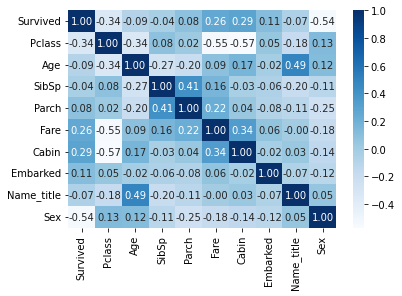

In [38]:
sns.heatmap(train.corr(), cmap='Blues' , annot=True, fmt=".2f")

### family = SibSp + Parch 파생변수
<pre>
1) train['family'] = SibSp(형제)  + Parch(부모자식) + 1

2) alone == family와 상관도가 높은 관계로 만들지 않기로 결정
   train['alone']  =  SibSp(형제)  + Parch(부모자식) ==> 혼자면1 아니면0
  
3) SibSp(형제)  + Parch(부모자식) drop



In [39]:
train['family'] = train['SibSp'] + train['Parch'] + 1
train[['SibSp','Parch','family']].head()

,SibSp,Parch,family
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1


* 방법1) lambda 활용

In [40]:
# # -------- 컬럼 하나에만 람다 적용하는 경우
# # train['Age'] = train['Age'].apply(lambda x : 1 if x==20살 else 0) 

# # -------- 프레임 통째로 람다 적용하는 경우    , axis=1 추가
# train['alone'] = train.apply(lambda x : 1 if x['SibSp'] + x['Parch'] == 0 else 0, axis=1)
# train[['SibSp','Parch','family','alone']].head()

* 방법2) 컬럼+컬럼 연산

In [41]:
# train['alone']  =  train['SibSp'] + train['Parch'] == 0
# train['alone']  = train['alone'].astype('int')
# train[['SibSp','Parch','family','alone']].head()
# # train.info()

In [42]:
train = train.drop(['SibSp','Parch'], axis=1)
train.head()

,Survived,Pclass,Age,Fare,Cabin,Embarked,Name_title,Sex,family
0,0,3,22.0,7.2500,0,1,3,1,2
1,1,1,38.0,71.2833,3,2,4,0,2
2,1,3,26.0,7.9250,0,1,2,0,1
3,1,1,35.0,53.1000,3,1,4,0,2
4,0,3,35.0,8.0500,0,1,3,1,1


### Fare 구간화 (바이닝 )
* 구간화(바이닝) : 연속형 변수값을 특정 구간으로 나누어 범주형으로 변환하는 것

In [43]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

<AxesSubplot:>

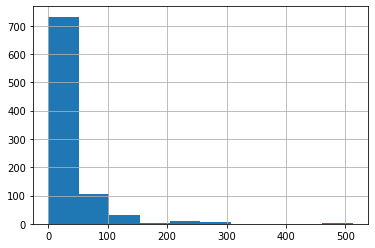

In [44]:
train['Fare'].hist()

<AxesSubplot:xlabel='Fare', ylabel='Count'>

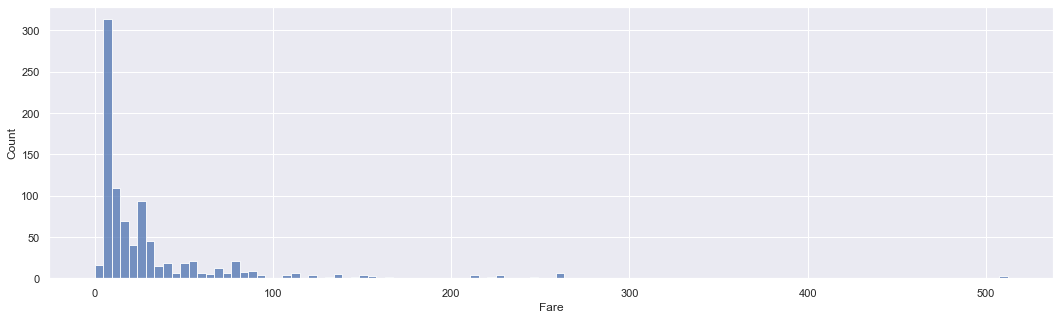

In [45]:
sns.set(rc={'figure.figsize':(18, 5)})
sns.histplot(data=train, x="Fare")

* 방법1) train.loc[조건, 컬럼] = 값

In [46]:
# train.loc[ train['Fare'] <=7.91   , 'Fare_binning' ] = 0
# train.loc[ (train['Fare'] >= 7.91) & (train['Fare'] <=14.45)   , 'Fare_binning' ] = 1


* 방법2) lambda

In [47]:
# def myfare(fare):   
#     res=0
#     if fare > -1 and fare <= 7.91:
#         res=0
#     elif fare > 7.91 and fare <=14.45:
#         res=1
#     elif fare > 14.46 and fare <=31.00:
#         res=2
#     elif fare > 31.00 and fare <=100.00:
#         res=3
#     elif fare > 100.00 and fare <= 200.00:
#         res=4
#     elif fare > 200.00 and fare <= 300.00:
#         res=5
#     else: 
#         res=6
#     return res
# #myfare(10)

# train['Fare_binning'] = train['Fare'].apply(lambda x : myfare(x))

* 방법3) cut() qcut()
<pre>
  cut(df , 3 )  : 일정 간격으로 등분
qcut(df , 3 )  : 일정 갯수로   등분

<img src="img1.png" width=400>

In [48]:
# train['Fare_binning'] = pd.cut(x=train['Fare'], bins=3, labels=['a','b','c'])
# train[['Fare_binning','Fare']].head()
# train[['Fare_binning']].value_counts()

<font color=red><b>
pd.cut( train[컬럼],  bins= [구간화] , labels=[구간화-1] )

In [49]:
train['Fare'].isna().sum()

0

In [50]:
train['Fare_binning'] = pd.cut(x=train['Fare'], 
                               bins=[-1.0, 7.91, 14.45, 31.00, 100.00, 200.00,300.00,600.00], 
                               labels= [1,2,3,4,5,6,7])
train['Fare_binning'] = train['Fare_binning'].astype('int')
train[['Fare_binning','Fare']].head()
train[['Fare_binning']].value_counts()

Fare_binning
3               229
1               223
2               217
4               169
5                33
6                17
7                 3
dtype: int64

In [51]:
# train[train['Fare_binning'].isna()][['Fare_binning','Fare']]

In [52]:
#pd.crosstab(train['Fare_binning'],train['Survived'])

In [53]:
# train['Fare_binning'] = pd.qcut(x=train['Fare'], q=3, labels=['a','b','c'])
# train[['Fare_binning','Fare']].head()
# train[['Fare_binning']].value_counts()

In [54]:
train.drop(['Fare'], axis=1, inplace=True)

In [55]:
train.head()

,Survived,Pclass,Age,Cabin,Embarked,Name_title,Sex,family,Fare_binning
0,0,3,22.0,0,1,3,1,2,1
1,1,1,38.0,3,2,4,0,2,4
2,1,3,26.0,0,1,2,0,1,2
3,1,1,35.0,3,1,4,0,2,4
4,0,3,35.0,0,1,3,1,1,2


### Age 구간화

In [56]:
train['Age'].describe()

count    891.000000
mean      29.757383
std       13.269151
min        0.420000
25%       21.993243
50%       30.000000
75%       35.576577
max       80.000000
Name: Age, dtype: float64

<AxesSubplot:xlabel='Age', ylabel='Count'>

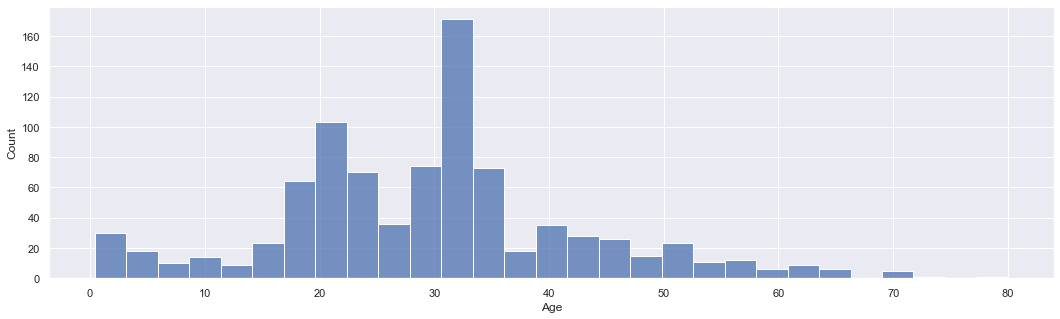

In [57]:
sns.set(rc={'figure.figsize':(18, 5)})
sns.histplot(data=train, x="Age")

<AxesSubplot:xlabel='Age', ylabel='Count'>

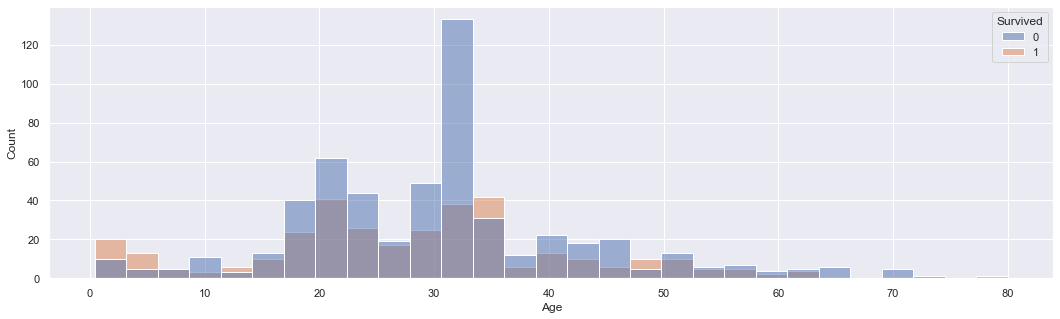

In [58]:
sns.histplot(data=train, x="Age", hue="Survived")

In [59]:
train['Age_binning'] = pd.cut(x=train['Age'], 
                               bins=[-1.0, 12, 18, 22, 27, 33, 40, 66, 500], 
                               labels= [1,2,3,4,5,6,7,8])
train['Age_binning'] = train['Age_binning'].astype('int')
train[['Age_binning','Age']].head()
train[['Age_binning']].value_counts()
train.drop('Age', axis=1, inplace=True)

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Survived      891 non-null    int64
 1   Pclass        891 non-null    int64
 2   Cabin         891 non-null    int8 
 3   Embarked      891 non-null    int64
 4   Name_title    891 non-null    int64
 5   Sex           891 non-null    int8 
 6   family        891 non-null    int64
 7   Fare_binning  891 non-null    int32
 8   Age_binning   891 non-null    int32
dtypes: int32(2), int64(5), int8(2)
memory usage: 43.6 KB


In [61]:
# train['family'].describe()

In [62]:
train.head()

,Survived,Pclass,Cabin,Embarked,Name_title,Sex,family,Fare_binning,Age_binning
0,0,3,0,1,3,1,2,1,3
1,1,1,3,2,4,0,2,4,6
2,1,3,0,1,2,0,1,2,4
3,1,1,3,1,4,0,2,4,6
4,0,3,0,1,3,1,1,2,6


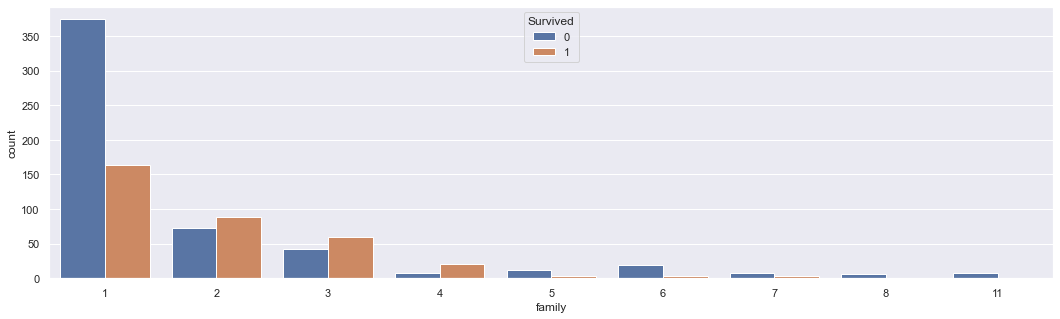

In [63]:
sns.countplot(data=train, x="family", hue="Survived")
# sns.histplot(data=train, x="family", hue="Survived", multiple="dodge")
train['family_binning'] = pd.cut(x=train['family'], bins=[0,1,4,7,11] , labels=[1,2,3,4])
train['family_binning'] = train['family_binning'].astype('int')
train.drop('family', axis=1, inplace=True)


In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Survived        891 non-null    int64
 1   Pclass          891 non-null    int64
 2   Cabin           891 non-null    int8 
 3   Embarked        891 non-null    int64
 4   Name_title      891 non-null    int64
 5   Sex             891 non-null    int8 
 6   Fare_binning    891 non-null    int32
 7   Age_binning     891 non-null    int32
 8   family_binning  891 non-null    int32
dtypes: int32(3), int64(4), int8(2)
memory usage: 40.2 KB


In [65]:
train.head()

,Survived,Pclass,Cabin,Embarked,Name_title,Sex,Fare_binning,Age_binning,family_binning
0,0,3,0,1,3,1,1,3,2
1,1,1,3,2,4,0,4,6,2
2,1,3,0,1,2,0,2,4,1
3,1,1,3,1,4,0,4,6,2
4,0,3,0,1,3,1,2,6,1


# 모델학습 & 평가

<pre><b>
지도학습   :   Supervised learning   : 분류(classsification), 회귀(regression)
비지도학습 : Unsupervised learning   : 군집(clustering)


## 문제지 답안지 분리

In [66]:
y = train['Survived']
X = train.drop(['Survived'], axis=1)
# print(y[:3])
# print(X.head())

In [67]:
X_train,X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2, 
                                                   random_state=1234,
                                                   shuffle=True
                                                   )
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(712, 8) (179, 8) (712,) (179,)


## 모델 선정 & 학습 & 예측 & 평가

In [68]:
def my_socre(y_test, pred):
    report = classification_report(y_test, pred)
    print(report)

    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)  #, average='binary')
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print(f"정확도{accuracy:.4f}  정밀도{precision:.4f}  재현률{recall:.4f}  f1{f1:.4f}")

In [69]:
model_list = [RandomForestClassifier(n_estimators=300, random_state=1234) ,
              LogisticRegression(penalty="l2", random_state=1234),
              KNeighborsClassifier(),
              DecisionTreeClassifier(),
              LinearSVC()
             ]
# model = RandomForestClassifier()
for model in model_list:
    model.fit(X_train, y_train)  #---학습해라
    pred = model.predict(X_test)
    #acc_score = accuracy_score(y_test, pred)
    print("--"*30)
    print(f"{model.__class__.__name__}")
    
    my_socre(y_test, pred)


------------------------------------------------------------
RandomForestClassifier
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       109
           1       0.85      0.74      0.79        70

    accuracy                           0.85       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179

정확도0.8492  정밀도0.8525  재현률0.7429  f10.7939
------------------------------------------------------------
LogisticRegression
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       109
           1       0.84      0.70      0.77        70

    accuracy                           0.83       179
   macro avg       0.84      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

정확도0.8324  정밀도0.8448  재현률0.7000  f10.7656
------------------------------------------------------------
KNeighborsClassifier
              pr

### 연습용 : precision_recall_curve(y_test, proba[:, 1])

In [70]:
model = RandomForestClassifier()
model.fit(X_train, y_train)  #---학습해라
pred = model.predict(X_test)
proba = model.predict_proba(X_test)
accuracy = accuracy_score(y_test, pred)
print(accuracy)

print("정답" , y_test.values[:5])
print("예측" , pred[:5])
print("예측확률\n", proba[:5])

my_socre(y_test, pred)

0.8491620111731844
정답 [1 0 0 1 0]
예측 [1 0 0 1 0]
예측확률
 [[0.         1.        ]
 [0.84162351 0.15837649]
 [0.99857143 0.00142857]
 [0.1        0.9       ]
 [0.5105     0.4895    ]]
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       109
           1       0.85      0.74      0.79        70

    accuracy                           0.85       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179

정확도0.8492  정밀도0.8525  재현률0.7429  f10.7939


[0.39106145 0.41463415 0.41717791 0.41975309 0.42236025] 
 [1.         0.97142857 0.97142857 0.97142857 0.97142857] 
 [0.         0.00142857 0.0025     0.00333333 0.00428571]
108 108 107


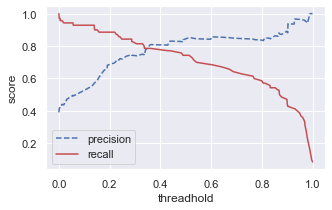

In [71]:
precision, recall, th = precision_recall_curve(y_test, proba[:, 1])
print(precision[:5],'\n', recall[:5], '\n',th[:5])
print(len(precision), len(recall), len(th))

sns.set(rc={'figure.figsize':(5, 3)})
plt.figure()
plt.xlabel("threadhold")
plt.ylabel("score")
plt.plot(th, precision[:len(th)], "b", linestyle="--", label='precision')
plt.plot(th, recall[:len(th)]   , "r", label='recall')
plt.legend()
plt.show()

<img width=300 src='https://www.researchgate.net/profile/Sooji-Han/publication/334506914/figure/fig1/AS:781491369955333@1563333470324/Precision-recall-curve.ppm'>

### 연습용 : roc_curve(y_test, proba[:, 1])
<pre>
양성에 대한 오답/정답 비율
X축 : F**P**R : 
Y축 : T**P**R : 

<img src="https://gusalsdmlwlq.github.io/assets/images/post2/roc_curve.png" widtdh=300>

[0. 0. 0. 0. 0.] 
 [0.         0.08571429 0.11428571 0.14285714 0.15714286] 
 [2.      1.      0.995   0.99125 0.99   ]
66 66 66


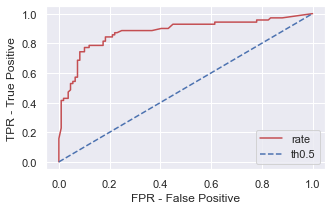

In [72]:
fpr, tpr, th = roc_curve(y_test, proba[:, 1])
print(fpr[:5],'\n', tpr[:5], '\n',th[:5])
print(len(fpr), len(tpr), len(th))

sns.set(rc={'figure.figsize':(5, 3)})
plt.figure()
plt.xlabel("FPR - False Positive")
plt.ylabel("TPR - True Positive")
plt.plot(fpr, tpr,     "r",   label='rate')
plt.plot([0,1], [0,1]  ,"b",  linestyle="--", label='random')
plt.legend()
plt.show()

### 연습용 : th 조절
* sklearn Default <b>threadholds > 0.5  --->  0.5보다 커야 1로 예측<b>

In [154]:
proba = model.predict_proba(X_test[:10])
print("model.predict_proba() \n", proba)
print(  (proba[:,1]>0.5))
print(  (proba[:,1]>0.5).astype(int))

print(  (proba[:,1]>0.47).astype(int))

model.predict_proba() 
 [[0.         1.        ]
 [0.84162351 0.15837649]
 [0.99857143 0.00142857]
 [0.1        0.9       ]
 [0.5105     0.4895    ]
 [0.51       0.49      ]
 [0.136      0.864     ]
 [0.69333333 0.30666667]
 [0.86088074 0.13911926]
 [0.09752778 0.90247222]]
[ True False False  True False False  True False False  True]
[1 0 0 1 0 0 1 0 0 1]
[1 0 0 1 1 1 1 0 0 1]


--- 
<pre>
proba = model.predict_proba(X_test)
<b>proba                        proba[:,1]>0.5    proba[:,1]>0.47</b>
 [[0.         1.        ]    1                 1 
 [0.84162351 0.15837649]     0                 0
 [0.99857143 0.00142857]     0                 0
 [0.1        0.9       ]     1                 1
 <font color=red>
 [0.5105     0.4895    ]     0                 1
 [0.51       0.49      ]     0                 1
 </font>
 [0.136      0.864     ]     1                 1
 [0.69333333 0.30666667]     0                 0
 [0.86088074 0.13911926]     0                 0
 [0.09752778 0.90247222]]    1                 1
</pre>
---

In [158]:
roc_df = pd.DataFrame(
    {
    'FPR'  : fpr, 
    'TPR'  : tpr, 
    'TH'   : th,
    'DIFF' : tpr - fpr}
)
print(roc_df.tail())
                  
roc_df[roc_df['DIFF'] == roc_df['DIFF'].max()]

         FPR       TPR        TH      DIFF
61  0.825688  0.957143  0.004718  0.131455
62  0.834862  0.971429  0.004693  0.136566
63  0.853211  0.971429  0.004286  0.118218
64  0.880734  0.971429  0.001429  0.090695
65  1.000000  1.000000  0.000000  0.000000


0.4383333333333333

In [148]:
# opt_th = 0.4383333333333333
opt_th = roc_df[roc_df['DIFF'] == roc_df['DIFF'].max()]['TH'].values[0]

print(opt_th)

proba = model.predict_proba(X_test)
print(proba[1:6])
pred = model.predict(X_test)
print(pred[1:6])
# -----------------------------------
re_proba = proba[:,1] >= opt_th   #  > 0.438333
print(re_proba[1:6].astype(int))

0.4383333333333333
[[0.84162351 0.15837649]
 [0.99857143 0.00142857]
 [0.1        0.9       ]
 [0.5105     0.4895    ]
 [0.51       0.49      ]]
[0 0 1 0 0]
[0 0 1 1 1]


### 임계치 조정 후 점수 확인

In [152]:
proba = model.predict_proba(X_test)
my_socre(y_test, pred)
print("--" * 30)

re_proba = proba[:,1] >= opt_th   #  > 0.438333
my_socre(y_test, re_proba)


              precision    recall  f1-score   support

           0       0.85      0.92      0.88       109
           1       0.85      0.74      0.79        70

    accuracy                           0.85       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179

정확도0.8492  정밀도0.8525  재현률0.7429  f10.7939
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       109
           1       0.83      0.77      0.80        70

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179

정확도0.8492  정밀도0.8308  재현률0.7714  f10.8000


<pre>
RandomForestClassifier정확도 : 0.810056
LogisticRegression정확도 : 0.821229
KNeighborsClassifier정확도 : 0.709497
DecisionTreeClassifier정확도 : 0.793296
LinearSVC정확도 : 0.759777
-----------------------------------------------평균나이 , Name_title
RandomForestClassifier 		 정확도:0.8268
LogisticRegression 		 정확도:0.8492
KNeighborsClassifier 		 정확도:0.7263
DecisionTreeClassifier 		 정확도:0.7989
LinearSVC 		 정확도:0.7430
----------------------------------------------- alone family 파생변수 추가
RandomForestClassifier 		 정확도:0.8268
LogisticRegression 		 정확도:0.8324
KNeighborsClassifier 		 정확도:0.7263
DecisionTreeClassifier 		 정확도:0.7933
LinearSVC 		 정확도:0.8101
RandomForestClassifier정확도 : 0.81005
----------------------------------------------- family 파생변수 추가
RandomForestClassifier 		 정확도:0.8324
LogisticRegression 		 정확도:0.8380
KNeighborsClassifier 		 정확도:0.7207
DecisionTreeClassifier 		 정확도:0.8045
LinearSVC 		 정확도:0.6201
----------------------------------------------- family 파생변수 추가, 요금구간화
RandomForestClassifier 		 정확도:0.8380
LogisticRegression 		 정확도:0.8212
KNeighborsClassifier 		 정확도:0.7933
DecisionTreeClassifier 		 정확도:0.7821
LinearSVC 		 정확도:0.8101
-----------------------------------------------  Fare , family, Age 구간화
RandomForestClassifier 		 정확도:0.8492
LogisticRegression 		 정확도:0.8324
KNeighborsClassifier 		 정확도:0.8101
DecisionTreeClassifier 		 정확도:0.8156
LinearSVC 		 정확도:0.8324


# 모델튜닝 & 검증


* confusion_matrix
<table border=1>
<tr>
<td>
    <table border=1>
    <tr>
    <td></td>
    <td colspan=2>예측<br>N&nbsp;&nbsp;P</td>
    </tr>
    <tr>
    <td rowspan=2>실N<br>제P</td>
    <td>TN</td>
    <td>FP</td>
    </tr>
    <tr>
    <td>FN</td>
    <td>TP</td>
    </tr>
    </table>
</td>
<td>
    $accuracy(정확도) = {TN+TP \over TN+FP+FN+TP}$ <br>
    $precision(정밀도) = {TP \over FP+TP}$ <br>
    $recall(재현률) = {TP \over FN+TP}$ <br>
    $TPR = Sensitivity(민감도) = {TP \over FN+TP}$ <br>
    $FPR (1-특이도) =  {FP \over TN+FP}$ <br>
    $Specificity(특이도) = TNR =  {TN \over TN+FP}$
</td>
</tr>
</table>